## Importing libraries 

In [1]:
import gzip
import gensim 
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy import std
from numpy import mean
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import FastText

from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
description = []
webindex = []
title = []
category = []
with open('job_ads.txt', mode='r', encoding='utf8') as f:  # open processed job ads from task 1
    lines = f.readlines()
    for i in lines:
        if i.startswith('Description'): #extract description lines
            description.append(i.strip()[13:]) #append to empty list       
        elif i.startswith('Webindex'): #extract webindex lines
            webindex.append(i.strip()[10:]) #append to empty list 
        elif i.startswith('Title'): #extract webindex lines
            title.append(i[7:].strip()) #append to empty list 
        elif i.startswith('Category'): #extract description lines
            category.append(i.strip()[10:]) #append to empty list

In [3]:
tokenized_text = [a.split(' ') for a in description] # tokenize text to feed into feature models
tokenized_title = [a.split() for a in title] # tokenize text to feed into feature models
res = [i + " " + j for i, j in zip(title, description)] # concats 'title' + 'description' into df
df = pd.DataFrame(list(zip(title, description, res)), # put all columns into df
               columns =['Title', 'Description', 'Title+Descr'])
title_and_desc = df['Title+Descr'].values.tolist() # prepare to feed into model
tokenized_td = [a.split() for a in title_and_desc] # tokenize text to feed into feature models
df['tk_text'] = tokenized_text
df['tk_title'] = tokenized_title
df['tk_titledescr'] = tokenized_td
df['Category'] = category # display 'category' into df
df

,Title,Description,Title+Descr,tk_text,tk_title,tk_titledescr,Category
0,Trainee Mortgage Advisor East Midlands,results driven person start career financial f...,Trainee Mortgage Advisor East Midlands result...,"[results, driven, person, start, career, finan...","[Trainee, Mortgage, Advisor, East, Midlands]","[Trainee, Mortgage, Advisor, East, Midlands, r...",Accounting_Finance
1,Credit Controller,exciting arisen consultancy city london add pe...,Credit Controller exciting arisen consultancy ...,"[exciting, arisen, consultancy, city, london, ...","[Credit, Controller]","[Credit, Controller, exciting, arisen, consult...",Accounting_Finance
2,Transaction Services Executive,transaction executive extensive bens bristol e...,Transaction Services Executive transaction exe...,"[transaction, executive, extensive, bens, bris...","[Transaction, Services, Executive]","[Transaction, Services, Executive, transaction...",Accounting_Finance
3,Audit Executive,audit senior bristol reputable mid tier practi...,Audit Executive audit senior bristol reputable...,"[audit, senior, bristol, reputable, mid, tier,...","[Audit, Executive]","[Audit, Executive, audit, senior, bristol, rep...",Accounting_Finance
4,Audit Assistant Manager,audit assistant bristol ambitious starter seek...,Audit Assistant Manager audit assistant bristo...,"[audit, assistant, bristol, ambitious, starter...","[Audit, Assistant, Manager]","[Audit, Assistant, Manager, audit, assistant, ...",Accounting_Finance
...,...,...,...,...,...,...,...
55444,Employee Engagement Officer,employee engagement officer liverpool basic bo...,Employee Engagement Officer employee engagemen...,"[employee, engagement, officer, liverpool, bas...","[Employee, Engagement, Officer]","[Employee, Engagement, Officer, employee, enga...",Teaching
55445,Support Worker (Summer Placement),broaden horizons broaden summer social care pl...,Support Worker (Summer Placement) broaden hori...,"[broaden, horizons, broaden, summer, social, c...","[Support, Worker, (Summer, Placement)]","[Support, Worker, (Summer, Placement), broaden...",Teaching
55446,Cover Supervisor Job,cover supervisor jobs staffordshire day hays e...,Cover Supervisor Job cover supervisor jobs sta...,"[cover, supervisor, jobs, staffordshire, day, ...","[Cover, Supervisor, Job]","[Cover, Supervisor, Job, cover, supervisor, jo...",Teaching
55447,Curriculum Leader Mathematics,curriculum leader mathematics tlr september ys...,Curriculum Leader Mathematics curriculum lead...,"[curriculum, leader, mathematics, tlr, septemb...","[Curriculum, Leader, Mathematics]","[Curriculum, Leader, Mathematics, curriculum, ...",Teaching


In [4]:
# create a description only file to aid in task 3
out_file_1 = open("./descONLY.txt", 'w',encoding = 'utf-8') # creates a txt file named './descONLY.txt', open in write mode and uses utf-8 encode
for ind in range(len(description)):
    out_file_1.write("{}\n".format(description[ind])) # writing description into our created txt in our desired format
out_file_1.close()# close the file

# create a title and description only file to aid in task 3
out_file_2 = open("./descANDtitle.txt", 'w',encoding = 'utf-8') # creates a txt file named './descANDtitle.txt', open in write mode and uses utf-8 encode
for ind in range(len(df)):
    out_file_2.write("{}\n".format(title_and_desc[ind])) # writing title and description into our created txt in our desired format
out_file_2.close()# close the file

### Saving outputs
Save the count vector representation as per spectification.
- count_vectors.txt

In [4]:
with open("vocab.txt") as f: # aid in generating the vocab for count vector representation for each review
    vocab = [r.split(":")[0] for r in f] # 'aa:1' current format, only want to extract the word, not the index
    vocab = set(vocab) # get unique vocab words

In [5]:
cVectorizer = CountVectorizer(ngram_range = (1,1), vocabulary = vocab) # initialised the CountVectorizer
count_features = cVectorizer.fit_transform(description) # generate the count vector representation for all description

In [7]:
def write_vectorFile(data_features,filename):
    num = data_features.shape[0] # the number of document
    out_file = open(filename, 'w') # creates a txt file and open to save the vector representation
    for a_ind in range(0, num): # loop through each article by index
        out_file.write("#{}".format(webindex[a_ind])) # start a new line after each article
        for f_ind in data_features[a_ind].nonzero()[1]: # for each word index that has non-zero entry in the data_feature
            value = data_features[a_ind][0,f_ind] # retrieve the value of the entry from data_features
            out_file.write(',') 
            out_file.write("{}:{}".format(f_ind,value)) # write the entry to the file in the format of word_index:value
        out_file.write('\n') # start a new line after each article
    out_file.close() # close the file

In [8]:
cVector_file = "count_vectors.txt" # file name of the count vector
write_vectorFile(count_features,cVector_file) # write the count vector to file

### Preparing count features based on title+description
Save the vector representation for task 3.

In [6]:
cVectorizer = CountVectorizer(ngram_range = (1,1), vocabulary = vocab) # initialised the CountVectorizer, only unigrams
count_features_title = cVectorizer.fit_transform(title) # generate the count vector representation for all titles

In [7]:
cVectorizer = CountVectorizer(ngram_range = (1,1), vocabulary = vocab) # initialised the CountVectorizer
count_features_titledesc = cVectorizer.fit_transform(title_and_desc) # generate the count vector representation for all titles and description

### Preparing tfidf wordweights for description and title+description
Functions for the tfidf vector representation to aid in task 2 and 3

In [5]:
def write_vectorFile(data_features,filename):
    num = data_features.shape[0] # the number of document
    out_file = open(filename, 'w') # creates a txt file and open to save the vector representation
    for a_ind in range(0, num): # loop through each article by index
        for f_ind in data_features[a_ind].nonzero()[1]: # for each word index that has non-zero entry in the data_feature
            value = data_features[a_ind][0,f_ind] # retrieve the value of the entry from data_features
            out_file.write("{}:{} ".format(f_ind,value)) # write the entry to the file in the format of word_index:value
        out_file.write('\n') # start a new line after each article
    out_file.close() # close the file

In [5]:
def gen_vocIndex(voc_fname):
    with open(voc_fname) as vocf: # 'a'level:0' <-- current format
        voc_Ind = [l.split(':') for l in vocf.read().splitlines()] # each line is 'index,word' 
    return {int(vi[1]):vi[0] for vi in voc_Ind} # changed to a dictionary format

# Generates the w_index:word dictionary
voc_fname = 'vocab.txt' # path for the vocabulary, currently a list 
voc_dict = gen_vocIndex(voc_fname)

In [6]:
def doc_wordweights(fName_tVectors, voc_dict):
    tfidf_weights = [] # a list to store the  word:weight dictionaries of documents
    
    with open(fName_tVectors) as tVecf: 
        tVectors = tVecf.read().splitlines() # each line is a tfidf vector representation of a document in string format 'word_index:weight word_index:weight .......'
    for tv in tVectors: # for each tfidf document vector
        tv = tv.strip()
        weights = tv.split(' ') # list of 'word_index:weight' entries
        weights = [w.split(':') for w in weights] # change the format of weight to a list of '[word_index,weight]' entries
        wordweight_dict = {voc_dict[int(w[0])]:w[1] for w in weights} # construct the weight dictionary, where each entry is 'word:weight'
        tfidf_weights.append(wordweight_dict) 
    return tfidf_weights

###### Tfidf weights for description (Task 2)

In [7]:
tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = vocab) # initialised the TfidfVectorizer
tfidf_features = tVectorizer.fit_transform(description) # generate the tfidf vector representation for all articles

In [16]:
tVector_file = "./tVector.txt" # file name of the tfidf vector
write_vectorFile(tfidf_features,tVector_file) # write the tfidf vector to file

In [8]:
fName_tVectors = 'tVector.txt'
tfidf_weights = doc_wordweights(fName_tVectors, voc_dict) # get the wordweights of description by passing the file and vocab to function doc_wordweights

###### Tfidf weights for title+description (Task 3)

In [9]:
tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = vocab) # initialised the TfidfVectorizer
titledesc_tfidf_features = tVectorizer.fit_transform(title_and_desc) # generate the tfidf vector representation for all titles and description

In [20]:
tVector_file = "./titledesctVector.txt" # file name of the tfidf vector
write_vectorFile(titledesc_tfidf_features,tVector_file) # write the tfidf vector to file

In [11]:
fName_tVectors = 'titledesctVector.txt'
titledescr_tfidf_weights = doc_wordweights(fName_tVectors, voc_dict) # get the wordweights of titles+description by passing the file and vocab to function doc_wordweights

## Task 2. Generating Feature Representations for Job Advertisement Descriptions

#======================> Fasttext - Non TFIDF Weighted

In [12]:
# 1. Set the corpus file names/path
corpus_file = 'descONLY.txt'

# 2. Initialise the Fast Text model
descFT = FastText(vector_size=200)  # instantiate

# 3. build the vocabulary
descFT.build_vocab(corpus_file=corpus_file) # sets the corpus_total_words (and also corpus_count) model attributes

# 4. train the model
descFT.train(
    corpus_file=corpus_file, epochs=descFT.epochs, # epoch refers to grouped batches
    total_examples=descFT.corpus_count, total_words=descFT.corpus_total_words)

descFT_wv = descFT.wv # ease of passing into param

2021-10-03 13:12:00,917 : INFO : FastText lifecycle event {'params': 'FastText(vocab=0, vector_size=200, alpha=0.025)', 'datetime': '2021-10-03T13:12:00.916837', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-10-03 13:12:00,924 : INFO : collecting all words and their counts
2021-10-03 13:12:00,928 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-10-03 13:12:01,997 : INFO : PROGRESS: at sentence #10000, processed 1085071 words, keeping 20704 word types
2021-10-03 13:12:02,997 : INFO : PROGRESS: at sentence #20000, processed 2164229 words, keeping 27607 word types
2021-10-03 13:12:03,995 : INFO : PROGRESS: at sentence #30000, processed 3255064 words, keeping 32554 word types
2021-10-03 13:12:05,101 : INFO : PROGRESS: at sentence #40000, processed 4437645 words, keeping 36822 word types
2021-10-03 13:12:06,193 : INFO : PROGRESS: at sentence #

In [13]:
def gen_docVecs_noweight(wv,tk_txts): # generate vector representation for documents without tfidf weightage
    docs_vectors = [] # creating empty final dataframe
    for i in range(0,len(tk_txts)):
        tokens = tk_txts[i]
        temp = [] # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
        for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                temp.append(word_vec) # if word is present then append it to temporary dataframe
            except:
                pass
        doc_vector = sum(temp) #  sum of all the word vectors (of all the words) in the document
        docs_vectors.append(doc_vector) # append each document value to the final dataframe
    return pd.DataFrame(docs_vectors)

In [14]:
descFT_dvs = gen_docVecs_noweight(descFT_wv,df['tk_text']) # pass in the feature model and tokenized description
descFT_dvs

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,48.321278,8.794600,-6.536752,52.633732,-87.282928,60.583534,-29.939392,54.100143,-56.227592,-2.146662,...,99.780655,-46.163860,-36.345390,-7.632975,40.182388,35.519516,70.226944,-58.372334,-4.904073,2.841304
1,8.820688,-0.030651,-23.400173,1.757951,-25.042145,8.206844,-6.094311,-1.274471,2.630031,-7.455265,...,19.298698,-3.530543,-4.691554,-2.555283,11.625706,4.475623,27.446449,2.822100,11.783042,-8.253469
2,39.974548,-8.088412,-20.213486,4.081716,-22.389086,31.019119,31.655773,5.476841,23.522343,-20.808937,...,40.557362,-15.493772,-23.371153,2.994698,20.699492,41.737076,18.906908,-38.615807,-7.243860,-9.890925
3,6.212758,-28.910639,-30.722521,-0.972874,-9.819381,42.432930,8.153742,20.383844,16.530289,-5.909323,...,8.187456,-5.525510,-49.357998,16.159580,4.654252,15.215240,33.846001,-4.384765,-39.543533,-2.855852
4,15.598625,-18.383993,-20.828392,6.893295,-39.493904,33.389351,-1.882038,28.447363,-21.878391,-3.329765,...,32.055191,-7.076105,-30.324984,19.142859,-6.412180,22.628387,28.785601,-10.832331,-9.554240,-5.030641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,83.752937,17.130852,-1.328403,21.838829,-51.459782,85.265938,32.944138,12.991662,-26.381302,-0.653045,...,57.880436,12.209999,-8.508501,-10.218342,32.039902,23.393000,46.075180,-82.910957,8.966228,46.314671
55445,135.322418,-106.454315,55.302387,107.773445,-103.607246,80.004845,-18.831957,76.025215,-160.148560,25.534634,...,148.363861,47.081097,-97.930901,12.103752,149.945206,-40.441265,98.359093,-80.065117,-54.881062,145.930206
55446,6.894279,-42.139832,-30.015453,-29.990414,-29.981600,42.563263,2.086731,-13.567530,13.846409,-52.170101,...,51.074928,21.436527,-22.560415,-1.895956,21.658539,23.070517,44.679482,-21.672487,-31.918428,104.572540
55447,79.431099,-52.505455,-40.679955,7.968993,-142.148804,30.303062,1.687244,46.253849,-18.245510,10.426311,...,120.882782,-29.622198,-55.559937,33.597244,62.403713,-20.643976,150.601501,-80.412392,-34.219753,100.427620


#======================>  Fastext - TFIDF Weighted

In [31]:
# extended version of the `gen_docVecs` function
def gen_docVecs(wv,tk_txts,tfidf = []): # generate vector representation for documents with tfidf weighting
    docs_vectors = pd.DataFrame() # creating empty final dataframe
    for i in range(0,len(tk_txts)):
        tokens = list(set(tk_txts[i])) # get the list of distinct words of the document

        temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
        for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                
                if tfidf != []:
                    word_weight = float(tfidf[i][word])
                else:
                    word_weight = 1
                temp = temp.append(pd.Series(word_vec*word_weight), ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                pass
        doc_vector = temp.sum() # take the sum of each column(w0, w1, w2,........w300)
        docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append each document value to the final dataframe
    return docs_vectors

In [27]:
# generate document embeddings
weighted_descFT_dvs = gen_docVecs(descFT_wv,df['tk_text'],tfidf_weights) # pass in the feature model and tokenized description and description tfidf weights
weighted_descFT_dvs.to_csv('weighted_ft.csv', index=False, sep='\t') # saved to csv prevent rerun each time

#======================>  W2V(Pre-trained) - Non TFIDF Weighted

In [15]:
# loading the pre-trained word2vec model based on google news
import gensim.downloader as api
preTW2v_wv = api.load('word2vec-google-news-300')

2021-10-03 11:50:18,540 : INFO : loading projection weights from C:\Users\loong/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
2021-10-03 11:52:28,285 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from C:\\Users\\loong/gensim-data\\word2vec-google-news-300\\word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-10-03T11:52:28.279745', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'load_word2vec_format'}


In [16]:
preTW2v_dvs = gen_docVecs_noweight(preTW2v_wv,df['tk_text']) # pass in the feature model and tokenized description

#======================>  W2V(Pre-trained) - TFIDF Weighted

In [30]:
# generate document embeddings
weighted_preTW2v_dvs = gen_docVecs(preTW2v_wv,df['tk_text'],tfidf_weights) # pass in the feature model and tokenized description and description tfidf weights
weighted_preTW2v_dvs.to_csv('weighted_w2v.csv', index=False, sep='\t') # saved to csv prevent rerun each time

#======================>  Glove(Pre-trained) - Non TFIDF Weighted

In [17]:
from utils import loadGloVe
fPath = "glove.6B.200d.txt" # selected a model with 200 dimension
preTGloVe_wv = loadGloVe(fPath) # load the GloVe embeddings

Found 400000 word vectors.


In [18]:
preTGloVe_dvs = gen_docVecs_noweight(preTGloVe_wv,df['tk_text']) # generate document embeddings by passing in the feature model and tokenized description

#======================>  Glove(Pre-trained) - TFIDF Weighted

In [33]:
# generate document embeddings
weighted_preTGloVe_dvs = gen_docVecs(preTGloVe_wv,df['tk_text'],tfidf_weights)
weighted_preTGloVe_dvs.to_csv('weighted_glove.csv', index=False, sep='\t') # saved to csv prevent rerun each time

## Task 3. Job Advertisement Classification

#======================> Evaluating the Best model out of 7 feature models

In [21]:
# files read are generated after running feature vectors, read from csv to save time from rerunning the weighted ones as it takes 5 hrs/run.
weighted_FT_dvs = pd.read_csv("weighted_ft.csv", sep = '\t')
weighted_preTW2v_dvs = pd.read_csv("weighted_w2v.csv", sep = '\t')
weighted_preTGloVe_dvs = pd.read_csv("weighted_glove.csv", sep = '\t')

Weighted FastText: tSNE 2 dimensional projected Feature space


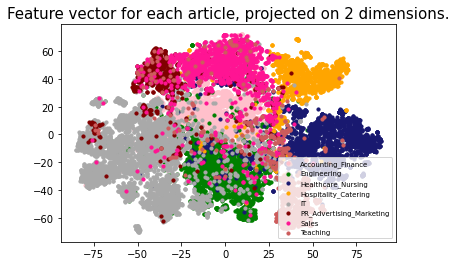

Accuracy:  0.8727682596934175
Cross Validation Accuracy: 0.847 (0.009)





In [23]:
def plotTSNE(labels,features): # features as a numpy array, each element of the array is the document embedding of an article
    categories = sorted(labels.unique())
    SAMPLE_SIZE = int(len(features) * 0.3) # sampling a subset of our dataset because t-SNE is computationally expensive
    np.random.seed(0)
    indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey', 'maroon', 'deeppink', 'indianred'] # seven colors for seven cat.
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])] # if point match the category project it into diagram
        plt.scatter(points[:, 0], points[:, 1], s=10, c=colors[i], label=categories[i]) # set the x, y axis
    plt.title("Feature vector for each article, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    plt.legend(loc=4, prop={'size': 'x-small'}) # set legend font and location lower right.
    plt.show()
    
seed = 0

# output plots only our weighted fasttext to show example visualization for submission, evaluation of all models are in MD below
models = [weighted_FT_dvs, descFT_dvs, weighted_preTW2v_dvs, preTW2v_dvs, weighted_preTGloVe_dvs, preTGloVe_dvs, count_features]
model_names = ["Weighted FastText", "Non-Weighted FastText", "Weighted Pretrained W2V", "Non-Weighted Pretrained W2V", "Weighted Pretrained GloVe", "Non-Weighted Pretrained GloVe", "Count Features"]

for i in range(0,len(models)): #loop through each model
    dv = models[i]
    name = model_names[i]
    features = dv.to_numpy() # convert the dataframe stored features to an numpy array
    print(name + ": tSNE 2 dimensional projected Feature space")
    plotTSNE(df['Category'],features) # labels is category in this case
    
    # creating training and test split
    X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(dv, df['Category'], list(range(0,len(df))),test_size=0.20, random_state=seed)
    cv = KFold(n_splits=5, random_state=1, shuffle=True) # prepare the cross-validation procedure
    # evaluate model
    model = LogisticRegression(max_iter = 6000,random_state=seed) # max iter set for convergence, 2000 not large enough
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1) # default params to calc cross validation score
    
    
    print("Accuracy: ", model.score(X_test, y_test))
    print('Cross Validation Accuracy: %.3f (%.3f)' % (mean(scores), std(scores))) # get mean and standard deviation of cross val
    print('\n\n')

#======================> It is reasonable to infer that the BOW models performs best in 5 fold cross validation, with non-weighted pre-trained glove model performing the worst.

In [ ]:
'''
Visualization:

Unweighted models seem to be less partitioned and the points on the graph are more cluttered not to the category that they 
belong in whereas for the better performing models, they are almost always better parititoned between categories. Especially, 
for the worst performing model, 'pretrained glove', the categories and points on the graph are scattered almost randomly 
with no definite structure.

Results: Ranked by Accuracy

Count Features (BOW)
Accuracy:  0.8747520288548242
Cross Validation Scores: [0.86023445 0.84490532 0.87646528 0.86339044 0.86339044]
Cross Validation Accuracy: 0.862 (0.010)


Weighted FastText
Accuracy:  0.8727682596934175
Cross Validation Scores: [0.85302074 0.83047791 0.84896303 0.84941389 0.85482417]
Cross Validation Accuracy: 0.847 (0.009)


Non-Weighted FastText
Accuracy:  0.8676284941388639
Cross Validation Accuracy: 0.830 (0.012)


Weighted Pretrained W2V
Accuracy:  0.8645626690712354
Cross Validation Scores: [0.85978359 0.8399459  0.84535618 0.85121731 0.85392245]
Cross Validation Accuracy: 0.847 (0.007)


Non-Weighted Pretrained W2V 
Accuracy:  0.8586113615870153
Cross Validation Accuracy: 0.811 (0.011)


Weighted Pretrained GloVe
Accuracy:  0.8523895401262399
Cross Validation Scores: [0.84580703 0.80928765 0.83273219 0.84310189 0.84039675]
Cross Validation Accuracy: 0.824 (0.013) 


Non-Weighted Pretrained GloVe
Accuracy:  0.8522091974752029
Cross Validation Accuracy: 0.822 (0.012)

'''

## Task 3 Q2 - Models selected: BOW and Fasttext

###### Since, the top 2 feature model in task 2 is the count features and Weighted Fastext, we will be using them. Now, let's see whether more words/information mean higher accuracy. SPOILER: YES!

#======================> Evaluating with the Best model (count features) with job title, description and title+description

In [46]:
seed = 0
    
models = [count_features_titledesc, count_features_title, count_features]
model_names = ["BOW-TD", "BOW-Title", "BOW-Description"]

seed = 2
for i in range(0,len(models)): #loop through each model
    dv = models[i]
    name = model_names[i]
    features = dv.to_numpy() # convert the dataframe stored features to an numpy array
    print(name + ": tSNE 2 dimensional projected Feature space")
    plotTSNE(df['Category'],features)
    
    # creating training and test split
    X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(dv, df['Category'], list(range(0,len(df))),test_size=0.20)
    cv = KFold(n_splits=5, random_state=1, shuffle=True) # prepare the cross-validation procedure
    # evaluate model
    model = LogisticRegression(max_iter = 2000,random_state=seed) # max iter set for convergence
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1) # calc cross val accuracy score
    print("Accuracy: ", model.score(X_test, y_test))
    print('Cross Validation Accuracy: %.3f (%.3f)' % (mean(scores), std(scores))) # get mean and standard deviation of cross val
    print('\n\n')

Accuracy:  0.8809738503155996
Cross Validation Accuracy: 0.865 (0.003)



Accuracy:  0.8285843101893597
Cross Validation Accuracy: 0.801 (0.005)



Accuracy:  0.8694319206492336
Cross Validation Accuracy: 0.857 (0.009)





#======================> Next, we will use the new tfidf weights (title+description) to generate weighted dv with fasttext

In [20]:
# 1. Set the corpus file names/path
corpus_file = 'descANDtitle.txt' # load in the combined descr and title text

# 2. Initialise the Fast Text model
tdFT = FastText(vector_size=200)  # instantiate

# 3. build the vocabulary
tdFT.build_vocab(corpus_file=corpus_file) # sets the corpus_total_words (and also corpus_count) model attributes

# 4. train the model
tdFT.train(
    corpus_file=corpus_file, epochs=tdFT.epochs, # epoch refers to grouped batches
    total_examples=tdFT.corpus_count, total_words=tdFT.corpus_total_words)

tdFT_wv= tdFT.wv

2021-10-03 12:30:32,129 : INFO : FastText lifecycle event {'params': 'FastText(vocab=0, vector_size=200, alpha=0.025)', 'datetime': '2021-10-03T12:30:32.129992', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-10-03 12:30:32,131 : INFO : collecting all words and their counts
2021-10-03 12:30:32,133 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-10-03 12:30:32,406 : INFO : PROGRESS: at sentence #10000, processed 1128984 words, keeping 26596 word types
2021-10-03 12:30:32,687 : INFO : PROGRESS: at sentence #20000, processed 2254555 words, keeping 37483 word types
2021-10-03 12:30:32,967 : INFO : PROGRESS: at sentence #30000, processed 3403222 words, keeping 46163 word types
2021-10-03 12:30:33,243 : INFO : PROGRESS: at sentence #40000, processed 4642209 words, keeping 54461 word types
2021-10-03 12:30:33,523 : INFO : PROGRESS: at sentence #

In [22]:
# altered extended version of the `gen_docVecs` function 
def gen_docVec(wv,tk_txts,tfidf = []): # generate vector representation for documents with tfidf weighting
    docs_vectors = [] # creating empty final dataframe
    for i in range(0,len(tk_txts)):
        tokens = list(set(tk_txts[i])) # get the list of distinct words of the document

        temp = []  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
        for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                
                if tfidf != []:
                    word_weight = float(tfidf[i][word])
                else:
                    word_weight = 1
                temp.append(word_vec*word_weight) # if word is present then append it to temporary dataframe
            except:
                pass
        doc_vector = sum(temp) # take the sum of each column(w0, w1, w2,........w300)
        docs_vectors.append(doc_vector) # append each document value to the final dataframe
    return pd.DataFrame(docs_vectors)

non_weighted_titledescFT_dvs = gen_docVecs_noweight(tdFT_wv,df['tk_titledescr']) # apply function using fastext model built on extra information title+descr
weighted_titledescFT_dvs = gen_docVec(tdFT_wv,df['tk_titledescr'],titledescr_tfidf_weights) # apply function using fastext model built on extra information title+descr

In [ ]:
seed = 0
    
models = [non_weighted_titledescFT_dvs, weighted_titledescFT_dvs]
model_names = ["Non-Weighted FT-TD", "Weighted FT-TD"]

seed = 2
for i in range(0,len(models)): #loop through each model
    dv = models[i]
    name = model_names[i]
    features = dv.to_numpy() # convert the dataframe stored features to an numpy array
    print(name + ": tSNE 2 dimensional projected Feature space")
    plotTSNE(df['Category'],features)
    
    # creating training and test split
    X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(dv, df['Category'], list(range(0,len(df))),test_size=0.20)
    cv = KFold(n_splits=5, random_state=1, shuffle=True) # prepare the cross-validation procedure
    # evaluate model
    model = LogisticRegression(max_iter = 2000,random_state=seed) # max iter set for convergence
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1) # calc cross val accuracy score
    print("Accuracy: ", model.score(X_test, y_test))
    print('Cross Validation Accuracy: %.3f (%.3f)' % (mean(scores), std(scores))) # get mean and standard deviation of cross val
    print('\n\n')

#======================> Evaluating the Accuracy of Weighted Fasttext with job title+description

In [41]:
'''

Looking at the results, more information = more accuracy!
-----------------------------------------------------------------------------------------------------------
Results: Description

Bag of Word
Accuracy:  0.8747520288548242
Cross Validation Accuracy: 0.862 (0.010)

Weighted FastText
Accuracy:  0.8707682596934175
Cross Validation Accuracy: 0.845 (0.009)


Non-Weighted FastText
Accuracy:  0.857619477006312
Cross Validation Accuracy: 0.827 (0.007)
-----------------------------------------------------------------------------------------------------------
Results: Title

Bag of Word
Accuracy:  0.8285843101893597
Cross Validation Accuracy: 0.801 (0.005)

As you can see, title achieves the lowest accuracy even compared to the feature models in task 2. Maybe because
there's less information?

-----------------------------------------------------------------------------------------------------------
Results: Description + Title

Bag of Word
Accuracy:  0.8809738503155996
Cross Validation Accuracy: 0.865 (0.003)

Weighted FastText
Accuracy:  0.8710550045085663
Cross Validation Accuracy: 0.846 (0.002)

Non-Weighted FastText
Accuracy:  0.8677186654643824
Cross Validation Accuracy: 0.836 (0.009)

Thus, we can conclude more information = higher accuracy!
'''

In [ ]:
''' 
-----------------------------------------------------------------------------------------------------------
Extra findings using Naiva Bayes and SVM shows that more info = higher accuracy

Title:
Naive Bayes Accuracy Score ->  82.01382626991284
Cross Validation NB Accuracy: 0.792 (0.007)
SVM Accuracy Score ->  84.1238352870454
Cross Validation SVM Accuracy: 0.822 (0.006)


Description:
Naive Bayes Accuracy Score ->  87.00330628193568
Cross Validation NB Accuracy: 0.863 (0.005)
SVM Accuracy Score ->  88.72257288848813
Cross Validation SVM Accuracy: 0.879 (0.005)


Title + Description:
Naive Bayes Accuracy Score ->  87.21370604147882
Cross Validation NB Accuracy: 0.865 (0.005)
SVM Accuracy Score ->  89.20348662458672
Cross Validation SVM Accuracy: 0.884 (0.004)

-----------------------------------------------------------------------------------------------------------
--example code snippet

X_train, X_test, y_train, y_test= train_test_split(df['Title+Descr'],df['Category'],test_size=0.3, random_state=2)
cv = KFold(n_splits=5, random_state=1, shuffle=True)
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(title_and_desc)
X_train_tfidf = Tfidf_vect.transform(X_train)
X_test_tfidf = Tfidf_vect.transform(X_test)

# Classifier- Naive Bayes
# fit the training dataset on the classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train_tfidf,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test_tfidf)
scores = cross_val_score(Naive, X_test_tfidf, y_test, scoring='accuracy', cv=cv, n_jobs=-1)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)
print('Cross Validation NB Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto') # small C -> higher bias, low variance
SVM.fit(X_train_tfidf,y_train)
scores = cross_val_score(SVM, X_test_tfidf, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test_tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)
print('Cross Validation SVM Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

'''

## Summary
This assignment allowed me to experiment and use NLP for real life applications to gain meaningful insights and predictions. In the last task, I learnt for sure that more information often times help in predicting labels and improve the overall performance of the model. Also, there are different feature models that perform differently depending on the task and size of the data, pre-trained models give that extra 'edge' to help us in extracting feature representations while custom trained models have its own advantage, if the data is large enough to train and learn on. 

Especially in this assignment, often times, there could be wrong inputs by user or misclassification of data that could affect any kinds of analysis, thus it is important to always visualize and extract important features to make sense of the large scale data.